In [1]:
import gymnasium as gym
import torch
from torch.utils.tensorboard import SummaryWriter
import tianshou as ts
from tianshou.data import CollectStats
from tianshou.utils.space_info import SpaceInfo
import argparse
import os
import pickle

import gymnasium as gym
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter

from tianshou.data import (
    Collector,
    CollectStats,
    PrioritizedVectorReplayBuffer,
    VectorReplayBuffer,
)

import frozenlake
import cliffwalking
import blackjack

from tianshou.env import DummyVectorEnv
from tianshou.policy import RainbowPolicy
from tianshou.policy.base import BasePolicy
from tianshou.policy.modelfree.rainbow import RainbowTrainingStats
import tianshou.policy.modelfree.rainbow as rainbow
from tianshou.trainer import OffpolicyTrainer
from tianshou.utils import TensorboardLogger
from tianshou.utils.net.common import Net
from tianshou.utils.net.discrete import NoisyLinear
from tianshou.utils.space_info import SpaceInfo

%load_ext autoreload
%autoreload 2

In [2]:
envs_names = ["CustomBlackjack-v0", "CustomCliffWalking-v0", "FrozenLakeCustom-v0"]
reward_threshholds = [500, 500, 500]
def get_args(env_idx) -> argparse.Namespace:
    parser = argparse.ArgumentParser()
    parser.add_argument("--task", type=str, default=envs_names[env_idx])
    parser.add_argument("--reward-threshold", type=float, default=reward_threshholds[env_idx])
    parser.add_argument("--seed", type=int, default=1626)
    parser.add_argument("--eps-test", type=float, default=0.05)
    parser.add_argument("--eps-train", type=float, default=0.1)
    parser.add_argument("--buffer-size", type=int, default=20000)
    parser.add_argument("--lr", type=float, default=1e-3)
    parser.add_argument("--gamma", type=float, default=0.9)
    parser.add_argument("--num-atoms", type=int, default=51)
    parser.add_argument("--v-min", type=float, default=-10.0)
    parser.add_argument("--v-max", type=float, default=10.0)
    parser.add_argument("--noisy-std", type=float, default=0.1)
    parser.add_argument("--n-step", type=int, default=3)
    parser.add_argument("--target-update-freq", type=int, default=320)
    parser.add_argument("--epoch", type=int, default=20)
    parser.add_argument("--step-per-epoch", type=int, default=2000)
    parser.add_argument("--step-per-collect", type=int, default=8)
    parser.add_argument("--update-per-step", type=float, default=0.125)
    parser.add_argument("--batch-size", type=int, default=64)
    parser.add_argument("--hidden-sizes", type=int, nargs="*", default=[128, 128, 128, 128])
    parser.add_argument("--training-num", type=int, default=8)
    parser.add_argument("--test-num", type=int, default=100)
    parser.add_argument("--logdir", type=str, default="log")
    parser.add_argument("--render", type=float, default=0.0)
    parser.add_argument("--prioritized-replay", action="store_true", default=False)
    parser.add_argument("--alpha", type=float, default=0.6)
    parser.add_argument("--beta", type=float, default=0.4)
    parser.add_argument("--beta-final", type=float, default=1.0)
    parser.add_argument("--resume", action="store_true", default=False)
    parser.add_argument(
        "--device",
        type=str,
        default="cuda" if torch.cuda.is_available() else "cpu",
    )
    parser.add_argument("--save-interval", type=int, default=4)
    return parser.parse_known_args()[0]



In [3]:
def train(env_idx):
    rainbow.RESULTS = []
    args: argparse.Namespace = get_args(env_idx)
    env = gym.make(args.task)
    assert isinstance(env.action_space, gym.spaces.Discrete)
    space_info = SpaceInfo.from_env(env)
    args.state_shape = space_info.observation_info.obs_shape
    args.action_shape = space_info.action_info.action_shape
    if args.reward_threshold is None:
        default_reward_threshold = {"BoyanChain": 200}
        args.reward_threshold = default_reward_threshold.get(
            args.task,
            env.spec.reward_threshold if env.spec else None,
        )
    # train_envs = gym.make(args.task)
    # you can also use tianshou.env.SubprocVectorEnv
    train_envs = DummyVectorEnv([lambda: gym.make(args.task) for _ in range(args.training_num)])
    # test_envs = gym.make(args.task)
    test_envs = DummyVectorEnv([lambda: gym.make(args.task) for _ in range(args.test_num)])
    # seed
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    train_envs.seed(args.seed)
    test_envs.seed(args.seed)
    # model
    def noisy_linear(x: int, y: int) -> NoisyLinear:
        return NoisyLinear(x, y, args.noisy_std)
    net = Net(
        state_shape=args.state_shape,
        action_shape=args.action_shape,
        hidden_sizes=args.hidden_sizes,
        device=args.device,
        softmax=True,
        num_atoms=args.num_atoms,
        dueling_param=({"linear_layer": noisy_linear}, {"linear_layer": noisy_linear}),
    )
    optim = torch.optim.Adam(net.parameters(), lr=args.lr)
    policy: RainbowPolicy[RainbowTrainingStats] = RainbowPolicy(
    model=net,
    optim=optim,
    discount_factor=args.gamma,
    action_space=env.action_space,
    num_atoms=args.num_atoms,
    v_min=args.v_min,
    v_max=args.v_max,
    estimation_step=args.n_step,
    target_update_freq=args.target_update_freq,
    ).to(args.device)
    # buffer
    buf: PrioritizedVectorReplayBuffer | VectorReplayBuffer
    if args.prioritized_replay:
        buf = PrioritizedVectorReplayBuffer(
            args.buffer_size,
            buffer_num=len(train_envs),
            alpha=args.alpha,
            beta=args.beta,
            weight_norm=True,
        )
    else:
        buf = VectorReplayBuffer(args.buffer_size, buffer_num=len(train_envs))
    # collector
    train_collector = Collector[CollectStats](policy, train_envs, buf, exploration_noise=True)
    test_collector = Collector[CollectStats](policy, test_envs, exploration_noise=True)
    # policy.set_eps(1)
    train_collector.reset()
    train_collector.collect(n_step=args.batch_size * args.training_num)
    
    # log
    log_path = os.path.join(args.logdir, args.task, "rainbow")
    writer = SummaryWriter(log_path)
    logger = TensorboardLogger(writer, save_interval=args.save_interval)
    def save_best_fn(policy: BasePolicy) -> None:
        torch.save(policy.state_dict(), os.path.join(log_path, "policy.pth"))
    def stop_fn(mean_rewards: float) -> bool:
        return mean_rewards >= args.reward_threshold
    def train_fn(epoch: int, env_step: int) -> None:
        # eps annealing, just a demo
        if env_step <= 10000:
            policy.set_eps(args.eps_train)
        elif env_step <= 50000:
            eps = args.eps_train - (env_step - 10000) / 40000 * (0.9 * args.eps_train)
            policy.set_eps(eps)
        else:
            policy.set_eps(0.1 * args.eps_train)
        # beta annealing, just a demo
        if args.prioritized_replay:
            if env_step <= 10000:
                beta = args.beta
            elif env_step <= 50000:
                beta = args.beta - (env_step - 10000) / 40000 * (args.beta - args.beta_final)
            else:
                beta = args.beta_final
            buf.set_beta(beta)
    def test_fn(epoch: int, env_step: int | None) -> None:
        policy.set_eps(args.eps_test)
    
        # trainer
    result = OffpolicyTrainer(
        policy=policy,
        train_collector=train_collector,
        test_collector=test_collector,
        max_epoch=args.epoch,
        step_per_epoch=args.step_per_epoch,
        step_per_collect=args.step_per_collect,
        episode_per_test=args.test_num,
        batch_size=args.batch_size,
        update_per_step=args.update_per_step,
        train_fn=train_fn,
        test_fn=test_fn,
        stop_fn=stop_fn,
        logger=logger,
        resume_from_log=args.resume,
    ).run()
    return rainbow.RESULTS.copy()


In [4]:
results = []
for i in range(len(envs_names)):
    results.append(train(i))

                                                                        Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error

Epoch #1: test_reward: -0.280000 ± 0.928224, best_reward: -0.160000 ± 0.956243 in #0


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #2: test_reward: -0.270000 ± 0.936536, best_reward: -0.160000 ± 0.956243 in #0


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #3: 2001it [00:07, 259.66it/s, env_episode=4965, env_step=6000, gradient_step=750, len=1, n/ep=4, n/st=8, rew=-1.00]                          


Epoch #3: test_reward: 0.020000 ± 0.937870, best_reward: 0.020000 ± 0.937870 in #3


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #4: 2001it [00:08, 231.22it/s, env_episode=6358, env_step=8000, gradient_step=1000, len=1, n/ep=4, n/st=8, rew=-0.25]                          


Epoch #4: test_reward: -0.090000 ± 0.928386, best_reward: 0.020000 ± 0.937870 in #3


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #5: 2001it [00:09, 210.07it/s, env_episode=7817, env_step=10000, gradient_step=1250, len=1, n/ep=8, n/st=8, rew=-0.38]                        

Epoch #5: test_reward: -0.070000 ± 0.951367, best_reward: 0.020000 ± 0.937870 in #3


Epoch #6: 2001it [00:11, 170.25it/s, env_episode=9196, env_step=12000, gradient_step=1500, len=2, n/ep=5, n/st=8, rew=0.60]                          


Epoch #6: test_reward: -0.110000 ± 0.947576, best_reward: 0.020000 ± 0.937870 in #3


Epoch #7: 2001it [00:12, 164.45it/s, env_episode=10614, env_step=14000, gradient_step=1750, len=2, n/ep=3, n/st=8, rew=0.00]                          


Epoch #7: test_reward: 0.000000 ± 0.989949, best_reward: 0.020000 ± 0.937870 in #3


Epoch #8: 2001it [00:13, 151.59it/s, env_episode=11931, env_step=16000, gradient_step=2000, len=1, n/ep=6, n/st=8, rew=0.17]                          


Epoch #8: test_reward: -0.220000 ± 0.933595, best_reward: 0.020000 ± 0.937870 in #3


Epoch #9: 2001it [00:14, 136.44it/s, env_episode=13282, env_step=18000, gradient_step=2250, len=1, n/ep=7, n/st=8, rew=0.43]                          


Epoch #9: test_reward: -0.210000 ± 0.930537, best_reward: 0.020000 ± 0.937870 in #3


Epoch #10: 2001it [00:15, 127.02it/s, env_episode=14644, env_step=20000, gradient_step=2500, len=1, n/ep=6, n/st=8, rew=0.33]                          


Epoch #10: test_reward: -0.220000 ± 0.933595, best_reward: 0.020000 ± 0.937870 in #3


Epoch #11: 2001it [00:13, 147.68it/s, env_episode=16035, env_step=22000, gradient_step=2750, len=2, n/ep=2, n/st=8, rew=1.00]                          


Epoch #11: test_reward: -0.020000 ± 0.969330, best_reward: 0.020000 ± 0.937870 in #3


Epoch #12: 2001it [00:12, 161.44it/s, env_episode=17368, env_step=24000, gradient_step=3000, len=1, n/ep=4, n/st=8, rew=0.00]                          


Epoch #12: test_reward: 0.050000 ± 0.963068, best_reward: 0.050000 ± 0.963068 in #12


Epoch #13: 2001it [00:12, 162.90it/s, env_episode=18770, env_step=26000, gradient_step=3250, len=1, n/ep=6, n/st=8, rew=0.33]                          


Epoch #13: test_reward: -0.020000 ± 0.969330, best_reward: 0.050000 ± 0.963068 in #12


Epoch #14: 2001it [00:12, 163.48it/s, env_episode=20138, env_step=28000, gradient_step=3500, len=1, n/ep=7, n/st=8, rew=-0.14]


Epoch #14: test_reward: -0.070000 ± 0.972163, best_reward: 0.050000 ± 0.963068 in #12


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #15: 2001it [00:12, 164.10it/s, env_episode=21476, env_step=30000, gradient_step=3750, len=1, n/ep=5, n/st=8, rew=0.20]                          


Epoch #15: test_reward: 0.060000 ± 0.977957, best_reward: 0.060000 ± 0.977957 in #15


Epoch #16: 2001it [00:12, 154.48it/s, env_episode=22866, env_step=32000, gradient_step=4000, len=1, n/ep=6, n/st=8, rew=-0.50]                          


Epoch #16: test_reward: 0.090000 ± 0.970515, best_reward: 0.090000 ± 0.970515 in #16


Epoch #17: 2001it [00:12, 165.95it/s, env_episode=24249, env_step=34000, gradient_step=4250, len=1, n/ep=6, n/st=8, rew=0.17]                          


Epoch #17: test_reward: -0.050000 ± 0.963068, best_reward: 0.090000 ± 0.970515 in #16


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #18: 2001it [00:12, 156.41it/s, env_episode=25652, env_step=36000, gradient_step=4500, len=1, n/ep=5, n/st=8, rew=0.20]                          


Epoch #18: test_reward: 0.000000 ± 0.969536, best_reward: 0.090000 ± 0.970515 in #16


Epoch #19: 2001it [00:11, 170.51it/s, env_episode=27038, env_step=38000, gradient_step=4750, len=1, n/ep=6, n/st=8, rew=-0.17]                          


Epoch #19: test_reward: 0.100000 ± 0.964365, best_reward: 0.100000 ± 0.964365 in #19


Epoch #20: 2001it [00:12, 161.25it/s, env_episode=28404, env_step=40000, gradient_step=5000, len=1, n/ep=6, n/st=8, rew=0.33]                          


Epoch #20: test_reward: -0.020000 ± 0.948472, best_reward: 0.100000 ± 0.964365 in #19


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #1: 2001it [00:06, 330.79it/s, env_episode=0, env_step=2000, gradient_step=250, len=0, n/ep=0, n/st=8, rew=0.00]                          


Epoch #1: test_reward: -505.940000 ± 23.511197, best_reward: -505.940000 ± 23.511197 in #1


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #2: 2001it [00:06, 295.84it/s, env_episode=8, env_step=4000, gradient_step=500, len=564, n/ep=8, n/st=8, rew=-1752.00]                          


Epoch #2: test_reward: -592.070000 ± 113.961858, best_reward: -505.940000 ± 23.511197 in #1


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #3: 2001it [00:07, 263.84it/s, env_episode=17, env_step=6000, gradient_step=750, len=45, n/ep=0, n/st=8, rew=-45.00]                          


Epoch #3: test_reward: -490.110000 ± 73.813128, best_reward: -490.110000 ± 73.813128 in #3


Epoch #4: 2001it [00:08, 243.97it/s, env_episode=31, env_step=8000, gradient_step=1000, len=49, n/ep=0, n/st=8, rew=-99.00]                          


Epoch #4: test_reward: -1111.820000 ± 281.194857, best_reward: -490.110000 ± 73.813128 in #3


Epoch #5: 2001it [00:08, 225.56it/s, env_episode=31, env_step=10000, gradient_step=1250, len=49, n/ep=0, n/st=8, rew=-99.00]                          


Epoch #5: test_reward: -499.840000 ± 28.965055, best_reward: -490.110000 ± 73.813128 in #3


Epoch #6: 2001it [00:09, 209.47it/s, env_episode=39, env_step=12000, gradient_step=1500, len=500, n/ep=0, n/st=8, rew=-1094.00]                          


Epoch #6: test_reward: -509.900000 ± 32.834585, best_reward: -490.110000 ± 73.813128 in #3


Epoch #7: 2001it [00:10, 191.22it/s, env_episode=51, env_step=14000, gradient_step=1750, len=58, n/ep=0, n/st=8, rew=-58.00]                          


Epoch #7: test_reward: -528.710000 ± 49.092422, best_reward: -490.110000 ± 73.813128 in #3


Epoch #8: 2001it [00:10, 183.76it/s, env_episode=53, env_step=16000, gradient_step=2000, len=273, n/ep=0, n/st=8, rew=-273.00]                          


Epoch #8: test_reward: -623.750000 ± 96.366216, best_reward: -490.110000 ± 73.813128 in #3


Epoch #9: 2001it [00:11, 171.89it/s, env_episode=59, env_step=18000, gradient_step=2250, len=500, n/ep=0, n/st=8, rew=-500.00]                          


Epoch #9: test_reward: -130.960000 ± 101.940857, best_reward: -130.960000 ± 101.940857 in #9


Epoch #10: 2001it [00:12, 166.61it/s, env_episode=84, env_step=20000, gradient_step=2500, len=189, n/ep=0, n/st=8, rew=-387.00]                          


Epoch #10: test_reward: -58.740000 ± 43.367181, best_reward: -58.740000 ± 43.367181 in #10


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #11: 2001it [00:12, 162.62it/s, env_episode=110, env_step=22000, gradient_step=2750, len=123, n/ep=0, n/st=8, rew=-123.00]                          


Epoch #11: test_reward: -501.980000 ± 13.860000, best_reward: -58.740000 ± 43.367181 in #10


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #12: 2001it [00:12, 159.74it/s, env_episode=143, env_step=24000, gradient_step=3000, len=21, n/ep=0, n/st=8, rew=-21.00]                          


Epoch #12: test_reward: -177.180000 ± 174.084082, best_reward: -58.740000 ± 43.367181 in #10


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #13: 2001it [00:12, 160.19it/s, env_episode=181, env_step=26000, gradient_step=3250, len=33, n/ep=0, n/st=8, rew=-33.00]                          


Epoch #13: test_reward: -383.860000 ± 124.790226, best_reward: -58.740000 ± 43.367181 in #10


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #14: test_reward: -415.230000 ± 354.074028, best_reward: -58.740000 ± 43.367181 in #10


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #15: 2001it [00:12, 162.32it/s, env_episode=255, env_step=30000, gradient_step=3750, len=49, n/ep=0, n/st=8, rew=-49.00]                          


Epoch #15: test_reward: -603.950000 ± 133.098864, best_reward: -58.740000 ± 43.367181 in #10


Epoch #16: 2001it [00:12, 156.97it/s, env_episode=283, env_step=32000, gradient_step=4000, len=40, n/ep=0, n/st=8, rew=-40.00]                          


Epoch #16: test_reward: -502.970000 ± 16.888135, best_reward: -58.740000 ± 43.367181 in #10


Epoch #17: 2001it [00:12, 161.63it/s, env_episode=321, env_step=34000, gradient_step=4250, len=27, n/ep=0, n/st=8, rew=-27.20]                          


Epoch #17: test_reward: -389.440000 ± 136.535294, best_reward: -58.740000 ± 43.367181 in #10


Epoch #18: 2001it [00:12, 160.85it/s, env_episode=351, env_step=36000, gradient_step=4500, len=101, n/ep=0, n/st=8, rew=-101.33]                          


Epoch #18: test_reward: -250.860000 ± 265.170550, best_reward: -58.740000 ± 43.367181 in #10


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #19: 2001it [00:13, 145.18it/s, env_episode=388, env_step=38000, gradient_step=4750, len=25, n/ep=0, n/st=8, rew=-25.00]                      

Epoch #19: test_reward: -45.790000 ± 36.616470, best_reward: -45.790000 ± 36.616470 in #19


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch 

Epoch #20: test_reward: -103.200000 ± 116.877286, best_reward: -45.790000 ± 36.616470 in #19


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #1: test_reward: 0.000000 ± 0.000000, best_reward: 0.040000 ± 0.195959 in #0


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #2: test_reward: 0.080000 ± 0.271293, best_reward: 0.080000 ± 0.271293 in #2


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #3: test_reward: 0.030000 ± 0.170587, best_reward: 0.080000 ± 0.271293 in #2


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #4: test_reward: 0.010000 ± 0.099499, best_reward: 0.080000 ± 0.271293 in #2


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #5: test_reward: 0.050000 ± 0.217945, best_reward: 0.080000 ± 0.271293 in #2


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #6: test_reward: 0.080000 ± 0.271293, best_reward: 0.080000 ± 0.271293 in #2


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #7: 2001it [00:07, 264.56it/s, env_episode=1216, env_step=14000, gradient_step=1750, len=25, n/ep=1, n/st=8, rew=0.00]                          


Epoch #7: test_reward: 0.060000 ± 0.237487, best_reward: 0.080000 ± 0.271293 in #2


Epoch #8: 2001it [00:08, 242.57it/s, env_episode=1425, env_step=16000, gradient_step=2000, len=3, n/ep=1, n/st=8, rew=0.00]                          


Epoch #8: test_reward: 0.060000 ± 0.237487, best_reward: 0.080000 ± 0.271293 in #2


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #9: 2001it [00:08, 230.73it/s, env_episode=1613, env_step=18000, gradient_step=2250, len=10, n/ep=0, n/st=8, rew=0.00]                          


Epoch #9: test_reward: 0.050000 ± 0.217945, best_reward: 0.080000 ± 0.271293 in #2


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #10: test_reward: 0.010000 ± 0.099499, best_reward: 0.080000 ± 0.271293 in #2


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #11: test_reward: 0.110000 ± 0.312890, best_reward: 0.110000 ± 0.312890 in #11


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #12: test_reward: 0.060000 ± 0.237487, best_reward: 0.110000 ± 0.312890 in #11


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #13: test_reward: 0.060000 ± 0.237487, best_reward: 0.110000 ± 0.312890 in #11


Epoch #14: 2001it [00:08, 231.91it/s, env_episode=2688, env_step=28000, gradient_step=3500, len=11, n/ep=0, n/st=8, rew=0.00]                          


Epoch #14: test_reward: 0.090000 ± 0.286182, best_reward: 0.110000 ± 0.312890 in #11


Epoch #15: 2001it [00:08, 233.40it/s, env_episode=2934, env_step=30000, gradient_step=3750, len=9, n/ep=2, n/st=8, rew=0.50]                          


Epoch #15: test_reward: 0.020000 ± 0.140000, best_reward: 0.110000 ± 0.312890 in #11


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #16: 2001it [00:08, 223.61it/s, env_episode=3190, env_step=32000, gradient_step=4000, len=5, n/ep=0, n/st=8, rew=0.00]                          


Epoch #16: test_reward: 0.150000 ± 0.357071, best_reward: 0.150000 ± 0.357071 in #16


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #17: 2001it [00:08, 226.68it/s, env_episode=3393, env_step=34000, gradient_step=4250, len=4, n/ep=2, n/st=8, rew=0.00]                          


Epoch #17: test_reward: 0.040000 ± 0.195959, best_reward: 0.150000 ± 0.357071 in #16


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #18: test_reward: 0.060000 ± 0.237487, best_reward: 0.150000 ± 0.357071 in #16


Epoch #19: 2001it [00:08, 239.61it/s, env_episode=3704, env_step=38000, gradient_step=4750, len=3, n/ep=1, n/st=8, rew=0.00]                          


Epoch #19: test_reward: 0.040000 ± 0.195959, best_reward: 0.150000 ± 0.357071 in #16


Epoch #20: 2001it [00:08, 244.93it/s, env_episode=3875, env_step=40000, gradient_step=5000, len=6, n/ep=0, n/st=8, rew=0.00]                          


Epoch #20: test_reward: 0.040000 ± 0.195959, best_reward: 0.150000 ± 0.357071 in #16


In [5]:
from scipy.ndimage import gaussian_filter1d
def smooth_curve(data, sigma=2):
    data = np.array(data)
    return gaussian_filter1d(data, sigma=sigma)

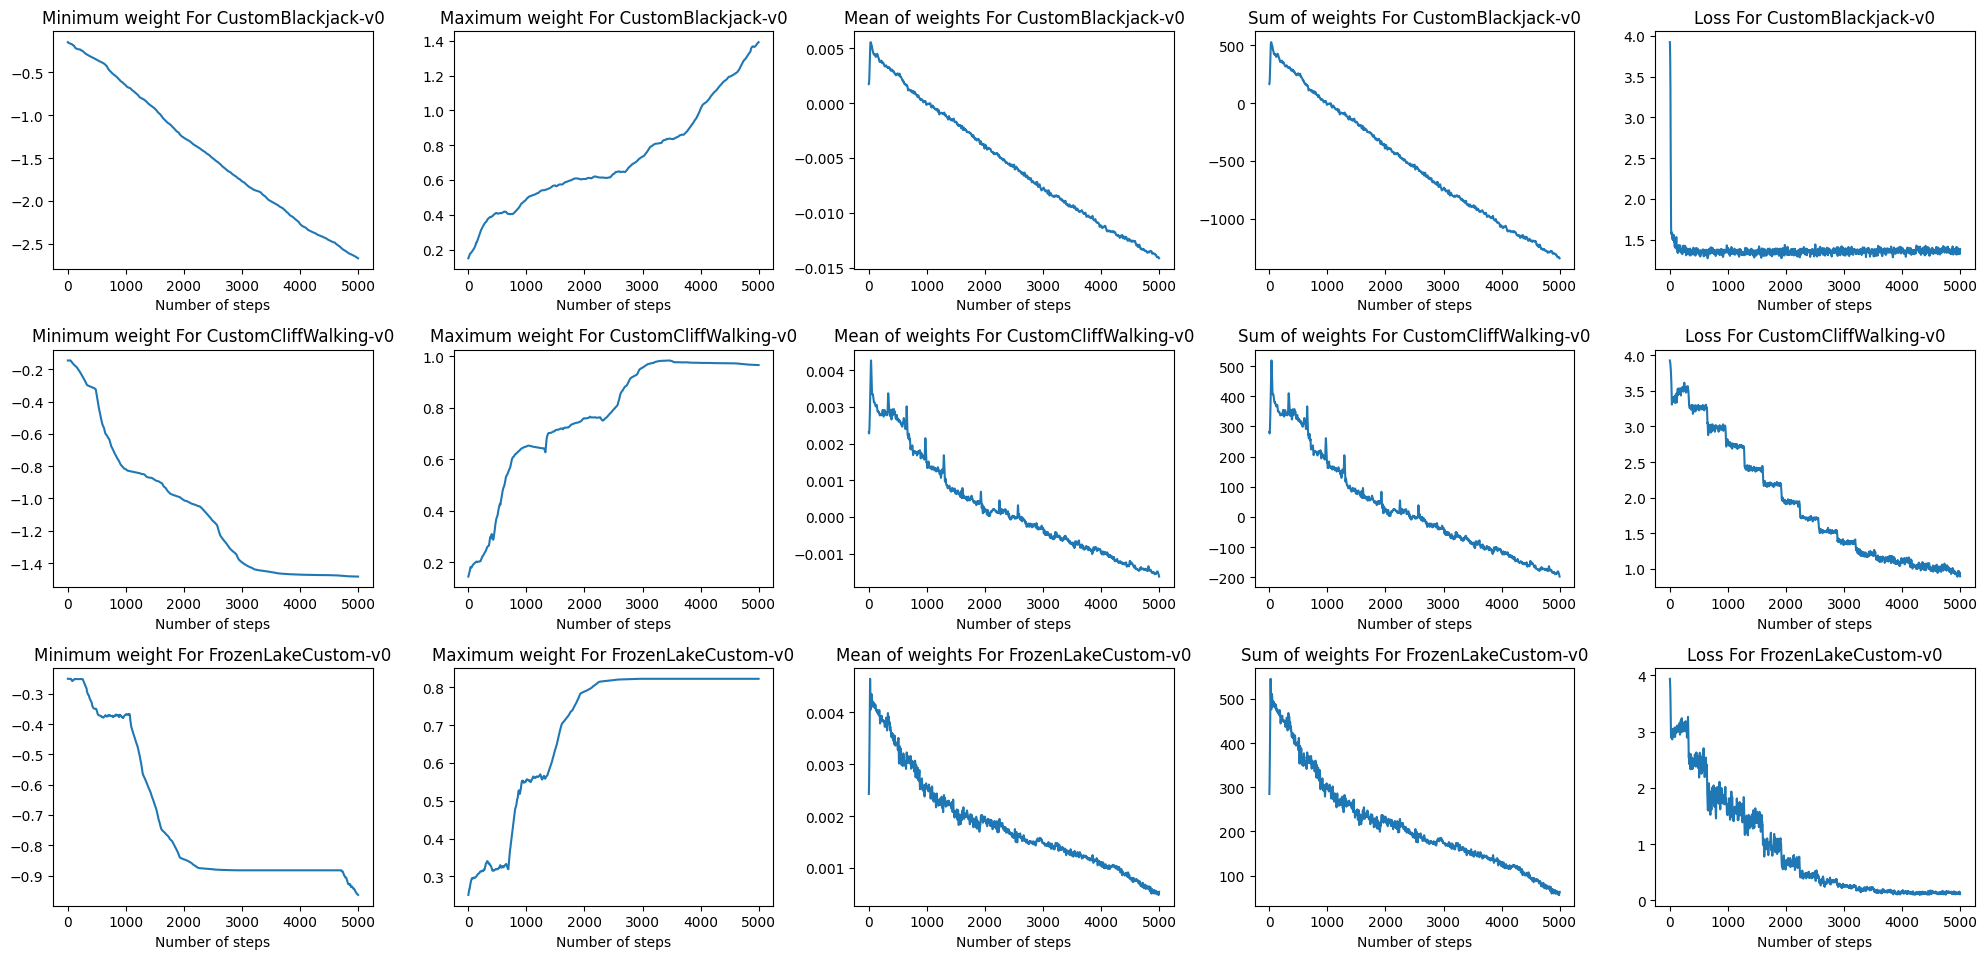

In [6]:
import matplotlib.pyplot as plt
import numpy as np
def plot_3x5_subplots(results, labels=None):
    """
    Plot a 3x5 grid of subplots using data from a 3D array.

    Parameters:
    - results: 3x5 list/array where results[i][j] contains (x, y1, y2, ..., yn) data for subplot[i][j]
    - titles: Optional 3x5 list of titles for each subplot
    - labels: Optional list of labels for each line in the plots (used in legends per column)
    """

    fig, axes = plt.subplots(3, 5, figsize=(20, 10), sharex=False, sharey=False)

    for i in range(3):
        data = results[i]
        data = np.array(data).T
        for j in range(5):
            ax = axes[i][j]
            if j == 4:
                data[j] = smooth_curve(data[j])
            ax.plot(data[j], label=labels[j])

            title = labels[j] + " For " + envs_names[i]
            ax.set_title(title)
            ax.set_xlabel("Number of steps")


    # # Add shared legends per column
    # for j in range(5):
    #     handles, legend_labels = axes[0][j].get_legend_handles_labels()
    #     if handles:
    #         fig.legend(handles, legend_labels, loc='upper center', ncol=len(legend_labels), bbox_to_anchor=(0.1 + j * 0.18, 1.03))

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# Line labels
labels = ["Minimum weight", "Maximum weight", "Mean of weights", "Sum of weights", "Loss"]

plot_3x5_subplots(results, labels)